In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import os
import sys
import cv2

In [21]:
# DB connection info
import psycopg2
from flask_test.my_secrets import DB_HOST_NAME, DB_USER_NAME, DB_PASSWORD, DB_NAME

# connection info
host = DB_HOST_NAME
user = DB_USER_NAME
password = DB_PASSWORD
database = DB_NAME

# conn
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

In [22]:
# fetch columns
sql_fetch_columns = '''
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'test';
'''
cursor.execute(sql_fetch_columns)
columns = cursor.fetchall()
print(columns)

[('id',), ('nose_y',), ('nose_x',), ('left_eye_y',), ('left_eye_x',), ('right_eye_y',), ('right_eye_x',), ('left_ear_y',), ('left_ear_x',), ('right_ear_y',), ('right_ear_x',), ('left_shoulder_y',), ('left_shoulder_x',), ('right_shoulder_y',), ('right_shoulder_x',), ('left_elbow_y',), ('left_elbow_x',), ('right_elbow_y',), ('right_elbow_x',), ('left_wrist_y',), ('left_wrist_x',), ('right_wrist_y',), ('right_wrist_x',), ('left_hip_y',), ('left_hip_x',), ('right_hip_y',), ('right_hip_x',), ('left_knee_y',), ('left_knee_x',), ('right_knee_y',), ('right_knee_x',), ('left_ankle_y',), ('left_ankle_x',), ('right_ankle_y',), ('right_ankle_x',), ('posture',)]


In [26]:
# fetch data
tcolumns = [i[0] for i in columns]
cursor.execute('SELECT * FROM test')
df = pd.DataFrame(cursor.fetchall(), columns=tcolumns)
df.head()

,id,nose_y,nose_x,left_eye_y,left_eye_x,right_eye_y,right_eye_x,left_ear_y,left_ear_x,right_ear_y,...,right_hip_x,left_knee_y,left_knee_x,right_knee_y,right_knee_x,left_ankle_y,left_ankle_x,right_ankle_y,right_ankle_x,posture
0,1,0.224724,0.180690,0.171005,0.260508,0.256466,0.584145,0.562766,0.716120,0.714130,...,0.067127,0.892858,0.049373,0.614970,0.231832,0.847839,0.091803,0.487925,0.171469,normal
1,2,0.212563,0.173660,0.163377,0.255518,0.254339,0.574703,0.562204,0.714703,0.706442,...,0.059023,0.891289,0.042751,0.597350,0.251428,0.848988,0.030209,0.510125,0.199230,normal
2,3,0.211320,0.172171,0.163140,0.255313,0.255689,0.574429,0.557909,0.703469,0.707272,...,0.071778,0.882540,0.049887,0.596596,0.234235,0.848916,0.034926,0.533189,0.221126,normal
3,4,0.217486,0.174529,0.166208,0.260370,0.256934,0.581748,0.560867,0.716823,0.705457,...,0.090167,0.891908,0.049379,0.612687,0.234709,0.844861,0.108538,0.508416,0.169340,normal
4,5,0.215368,0.172279,0.164355,0.261036,0.259061,0.582449,0.560954,0.716877,0.706465,...,0.061511,0.889584,0.021869,0.613312,0.216186,0.846489,0.031804,0.464366,0.153027,normal


In [147]:
# split data
X = df.drop(['id', 'posture'], axis=1)
y = df['posture'].copy()

class_names = y.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape

((846, 34), (282, 34), (376, 34))

In [163]:
encode_target_dict = {k:v for k, v in zip(class_names, range(len(class_names)))}
encode_target_dict

{'forward_head': 0, 'leaning': 1, 'normal': 2}

In [166]:
y_train = y_train.map(encode_target_dict)
y_val = y_val.map(encode_target_dict)
y_test = y_test.map(encode_target_dict)

In [167]:
# 분류 모델 생성
inputs = tf.keras.Input(shape=(34))

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 34)]              0         
                                                                 
 dense_79 (Dense)            (None, 128)               4480      
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 


 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 3)                 195       
                                                                 
Total params: 12,931
Trainable params: 12,931
Non-trainable params: 0
_________________________________________________________________


In [168]:
# 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [169]:
# 실행
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
48/53 [==========================>...] - ETA: 0s - loss: 1.1347 - accuracy: 0.3620 
Epoch 1: val_accuracy improved from -inf to 0.53901, saving model to weights.best.hdf5
53/53 [==============================] - 1s 5ms/step - loss: 1.1265 - accuracy: 0.3664 - val_loss: 1.0335 - val_accuracy: 0.5390
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.4385
Epoch 2: val_accuracy improved from 0.53901 to 0.60993, saving model to weights.best.hdf5
53/53 [==============================] - 0s 2ms/step - loss: 1.0442 - accuracy: 0.4385 - val_loss: 0.9612 - val_accuracy: 0.6099
Epoch 3/200
49/53 [==========================>...] - ETA: 0s - loss: 0.9769 - accuracy: 0.5395
Epoch 3: val_accuracy improved from 0.60993 to 0.63830, saving model to weights.best.hdf5
53/53 [==============================] - 0s 2ms/step - loss: 0.9723 - accuracy: 0.5426 - val_loss: 0.8715 - val_accuracy: 0.6383
Epoch 4/200
50/53 [===========================>..] - ETA: 0s

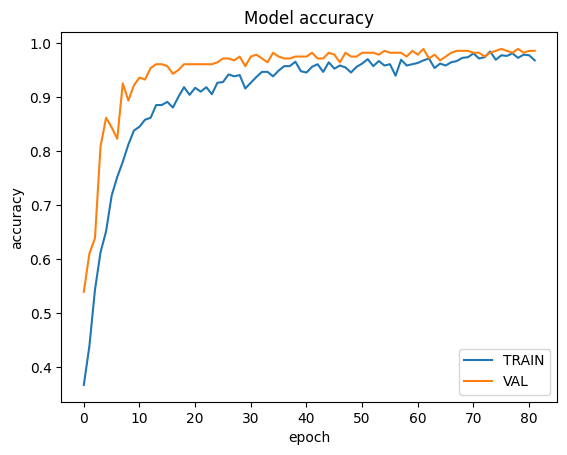

In [188]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [173]:
# Evaluate the model using the TEST dataset
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9761


12/12 [==============================] - 0s 1ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

forward_head       0.99      0.98      0.98       123
     leaning       0.96      0.98      0.97       125
      normal       0.98      0.97      0.97       128

    accuracy                           0.98       376
   macro avg       0.98      0.98      0.98       376
weighted avg       0.98      0.98      0.98       376



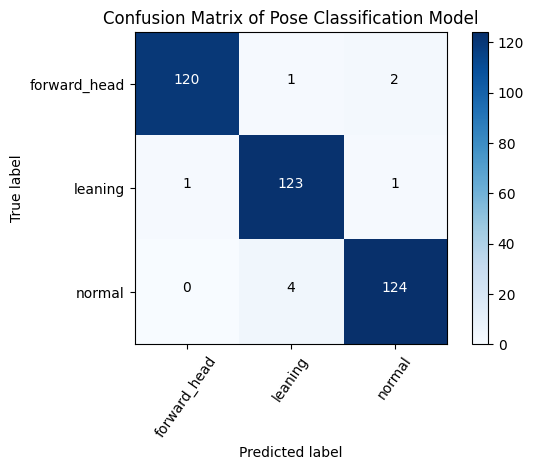

In [178]:
import itertools

# cm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in y_test]

# Plot the confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [187]:
import pickle

with open('my_model.pkl', 'wb') as file:
    pickle.dump(model, file)